In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [2]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        if "type" in msg:
            role = "😎 USER" if msg.type == "human" else "🤖 BOT"
            print(f"{role}: {msg.content}")

C:\Users\Putra Budiman\AppData\Local\Temp\ipykernel_7268\2056088697.py:67: ResourceWarning: unclosed <socket.socket fd=3968, family=2, type=1, proto=0, laddr=('127.0.0.1', 21877), raddr=('127.0.0.1', 11434)>
  tools_retriever = InMemoryVectorStore.from_documents(


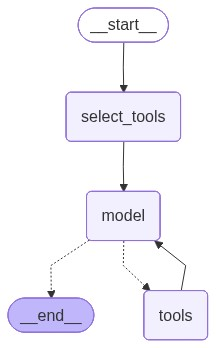

In [9]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings 

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import operator
import re
@tool
def calculator(query: str) -> str:
    """Alat kalkulator sederhana. Masukan harus berupa ekspresi matematika."""
    # Hanya izinkan angka, operator matematika, dan spasi
    if not re.match(r'^[0-9+\-*/(). ]+$', query):
        raise ValueError("Ekspresi hanya boleh mengandung angka dan operator matematika (+, -, *, /, ., ()")
    
    try:
        # Evaluasi ekspresi matematika dengan aman
        # Membatasi operasi hanya ke operator matematika dasar
        allowed_operators = {
            ast.Add: operator.add,
            ast.Sub: operator.sub,
            ast.Mult: operator.mul,
            ast.Div: operator.truediv,
            ast.USub: operator.neg,
            ast.UAdd: operator.pos,
        }

        def eval_math_expr(node):
            if isinstance(node, ast.Constant):  # Angka
                return node.value
            elif isinstance(node, ast.Num):  # Untuk Python versi lama
                return node.n
            elif isinstance(node, ast.BinOp):  # Operasi biner
                left = eval_math_expr(node.left)
                right = eval_math_expr(node.right)
                return allowed_operators[type(node.op)](left, right)
            elif isinstance(node, ast.UnaryOp):  # Operasi unary
                operand = eval_math_expr(node.operand)
                return allowed_operators[type(node.op)](operand)
            else:
                raise TypeError(f"Operasi tidak dikenal: {type(node)}")

        node = ast.parse(query, mode='eval').body
        result = eval_math_expr(node)
        
        # Konversi hasil ke string
        if isinstance(result, float) and result.is_integer():
            return str(int(result))
        return str(result)
    except Exception as e:
        raise ValueError(f"Ekspresi matematika tidak valid: {str(e)}")

search = DuckDuckGoSearchRun()
tools = [search, calculator]

embeddings =  OllamaEmbeddings(model="nomic-embed-text",base_url="http://localhost:11434")

model = ChatOpenAI(model=default_model_name,temperature=0.1)

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools],
    embeddings,
).as_retriever()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}

builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [10]:
input = {
  "messages": [
    HumanMessage("""Berapa usia presiden ke‑60 Amerika Serikat ketika
        dia meninggal ditambah selisih tahun sekarang? use tools""")
  ]
}
for c in graph.stream(input):
    print(c)

{'select_tools': {'selected_tools': ['calculator', 'duckduckgo_search']}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_96634861', 'function': {'arguments': '{"query":"usia John F. Kennedy saat meninggal dan tahun sekarang"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 707, 'prompt_tokens': 491, 'total_tokens': 1198, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 670, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 192, 'video_tokens': 0}, 'cost': 5.6207e-05, 'is_byok': True, 'cost_details': {'upstream_inference_cost': 0.00112414, 'upstream_inference_prompt_cost': 6.364e-05, 'upstream_inference_completions_cost': 0.0010605}}, 'model_name': 'x-ai/grok-code-fast-1', 'system_fingerprint': None, 'finish_reason': 'tool_call

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='No good DuckDuckGo Search Result was found', name='duckduckgo_search', id='8dc9dc28-27e1-4278-81f8-88cd1dbde73a', tool_call_id='call_96634861')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_57278198', 'function': {'arguments': '{"query":"usia John F. Kennedy saat meninggal"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 461, 'prompt_tokens': 546, 'total_tokens': 1007, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 427, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 448, 'video_tokens': 0}, 'cost': 3.6003e-05, 'is_byok': True, 'cost_details': {'upstream_inference_cost': 0.00072006, 'upstream_inference_prompt_cost': 2.856e-05, 'upstream_inference_completions_cost': 0.000691

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='USIA Anfangs USIWA, Abkürzung für "Uprawlenje Sowjetskim Imuschestwom w Awstrij" = Verwaltung des sowjetischen Vermögens in Österreich Am 5. Juli 1946 wurden in der sowjetischen Besatzungszone … Weltkrieg wurden vor allem Lkws mit MAN-Motoren produziert; nach 1945 lagen die stark zerstörten Floridsdorfer Fabriken in der sowjetischen Besatzungszone und wurden in die USIA eingegliedert, … Jan 13, 2018 · Durch den dauernden Wirtschaftsaufschwung nach dem Krieg, welcher von der KPÖ lediglich als kurzfristiger „Zyklus“ erklärt wurde, und das Ende der Besatzungszeit 1955 (wodurch die … Während des Zweiten Weltkrieges waren Dienststellen der deutschen Wehrmacht im Schloss untergebracht, weswegen es nach dem Krieg unter sowjetischer USIA -Verwaltung stand. 1951 kam das … Hauptplatz hinter dem Rathaus vom Stadtturm aus Korneuburg (Südansicht) vom Leopoldsberg aus Historische Karte: Wien und Umgebung (um 1888) Korneuburg ist eine Stadtgemeinde im …', 

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='USIA Anfangs USIWA, Abkürzung für "Uprawlenje Sowjetskim Imuschestwom w Awstrij" = Verwaltung des sowjetischen Vermögens in Österreich Am 5. Juli 1946 wurden in der sowjetischen … Weltkrieg wurden vor allem Lkws mit MAN-Motoren produziert; nach 1945 lagen die stark zerstörten Floridsdorfer Fabriken in der sowjetischen Besatzungszone und wurden in die USIA eingegliedert, … Jan 13, 2018 · Durch den dauernden Wirtschaftsaufschwung nach dem Krieg, welcher von der KPÖ lediglich als kurzfristiger „Zyklus“ erklärt wurde, und das Ende der Besatzungszeit 1955 (wodurch die … Während des Zweiten Weltkrieges waren Dienststellen der deutschen Wehrmacht im Schloss untergebracht, weswegen es nach dem Krieg unter sowjetischer USIA -Verwaltung stand. 1951 kam … Hauptplatz hinter dem Rathaus vom Stadtturm aus Korneuburg (Südansicht) vom Leopoldsberg aus Historische Karte: Wien und Umgebung (um 1888) Korneuburg ist eine Stadtgemeinde im …', name='duckduckgo_se

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='John 起源于《新约圣经》里的人物 John the Baptist （基督教和合本译为 施洗约翰，天主教译为 圣若翰洗者）。施洗约翰在约旦河中为人施洗礼，劝人悔改，是基督教的先行者，为耶稣宣讲 … 为什么「约翰」成为了 John 的主流译名？ 其实情况和「大卫」「彼得」类似，这些和《圣经》有关的名字，在规范的译音标准颁布前，就已经趋于统一。后来的规范直接沿用了《圣经》里「 … john是什么意思？john有两种意思，一种是作为名词，有几种含义盥洗室,厕所，男人；傻瓜，糊涂虫，嫖客，警察等；另一种是作为人名使用。在美国中，John是美国最常见的男子名，来源于 … Jul 25, 2012 · john和jhon一样吗当然不一样，大写的John只能作为人名使用，但是由于很多人总是将John拼错，所以会出现和jhon混用的情况。 约翰·温斯顿·列侬（John Winston Lennon，1940年10月9日—1980年12月8日），1940年出生于英国利物浦，英国摇滚乐队“披头士”成员，摇滚音乐家，诗人，社会活动家。 1952年9月，列侬 …', name='duckduckgo_search', id='af3eacd4-efff-4a24-acb3-1e896adb5970', tool_call_id='call_93777310')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_59430366', 'function': {'arguments': '{"query":"who is the 60th president of the United States"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1024, 'prompt_tokens': 1527, 'total_tokens'

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='CItizen Challan by APCFSS provides a platform for generating and managing challans for various financial transactions in Andhra Pradesh. With the Challan Reference form by visiting the bank citizen can make payment. On selecting the payment mode as “RTGS/NEFT” below screen will be displayed. Click on “OK’ button. … Mar 5, 2025 · Every citizen can check or track CFMS bill status through the AP State Portal (https://cfms.ap.gov.in/). Without delay, read the step by step procedure for citizen service to … Once the challan is generated with CFMS Transaction ID along with other details entered in the previous screens, the payer required to submit the challan Reference Form to the SBI bank. Open cfms.ap.gov.in website > Receipt Links > Challan Status. After that you must enter the ‘Transaction ID’, ‘Department Transaction Id’, ‘Challan Number’ and ‘Bank Reference Id’.', name='duckduckgo_search', id='1350b046-8fce-4cd5-8062-4e8e26fc2f20', tool_call

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Projects\examples-code-id-langchain-learning\.v

{'tools': {'messages': [ToolMessage(content='No good DuckDuckGo Search Result was found', name='duckduckgo_search', id='755ec890-80c1-49ad-b117-5adec1b3d123', tool_call_id='call_55274355'), ToolMessage(content='No good DuckDuckGo Search Result was found', name='duckduckgo_search', id='eb6069ce-015d-416f-a86e-3bfc2f686e52', tool_call_id='call_66913656'), ToolMessage(content='106', name='calculator', id='5e50d1c9-7450-4d37-9b20-72c834879504', tool_call_id='call_57415370'), ToolMessage(content='current，present，recent在表示形容词性的时候发生的时间不同、词性不同、在句型中用法不同。 一、表示形容词性的时候，表示发生的时间不同 1、current指目前存在和发生的。 2、recent表示新近的，最近的，时 … 请问为什么电压的英文是voltage,缩写却是u，而电流英文是current,缩写是I?通常物理量和该量的单位符号使用的字母是不同的。物理量的单位符号一般使用发明（发现）该物理量的科学家的姓氏（外国人姓名是名在前 … Feb 17, 2007 · I don\'t think current and present are generally interchangeable. Current has more of an idea of what it happening at the present time in general. The current theory is that the universe is expanding. … Nov 14, 2018 · Hello everyone, Does "current with" meanin